In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import six
from scipy import signal, linalg
import h5py
import glob
import pmefm
import lockin
from freqdemod import h5ls
from collections import OrderedDict
from enum import Enum
from munch import Munch
from decorator import decorator
from kpfm.util import h5filename
from sigutils import log_bins

Mod = Enum('Mod', 'x y xy')

@h5filename
def _h5toPMEFM(f, mod_direction):
    """For today's data (2017-02-22), note that the gains are all equal"""
    phi_t = f['CPD'][:]
    fs = f.attrs['Inputs.Scan rate [Hz]']
    dt = 1/fs
    T = phi_t.size * dt
    fx = f.attrs['Inputs.Pos Mod Freq (Hz)']
    if mod_direction == Mod.xy:
        scale_factor = 2
    else:
        scale_factor = np.sqrt(2)
    x_m = f.attrs['Inputs.Pos Mod rms (V)'] * scale_factor * 15 * 0.125 # 125 nm/V
    d = {key.replace("Inputs.", ""): val for key, val in fh.attrs.items()}
    X0 = d['X Start [V]']
    Y0 = d['Y Start [V] ']
    Xf = d['X End [V]']
    Yf = d['Y End [V] ']
    start = X0 + 1j * Y0
    end = Xf + 1j * Yf
    scan = end - start
    scan_size = abs(scan)
    x_tot = scan_size * 0.125
    v_tip = x_tot / T

    return Munch({'fs': fs, 'fx': fx, 'v_tip': v_tip, 'x_m': x_m, 'phi_t': phi_t})

def workup_file(fh_or_fname, mod_direction, fir, invert=False,
                x_m=None, plot_phase=True, iprint=0):
    pm = pmefm.PMEFMEx(**_h5toPMEFM(fh_or_fname, mod_direction))
    if x_m is not None:
        pm.x_m = x_m
    pm.fir_filter(fir_ac=fir, fir_dc=fir)
    pm.auto_phase(invert=invert, iprint=iprint)
    if plot_phase:
        pm.plot_phase()
    pm.output()
    return pm


def workup_dict(d, mod_direction, fir, replace_xm=True, plot_phase=True, iprint=0):
    if replace_xm:
        return OrderedDict(
    (key, workup_file(fname, Mod.xy, fir, invert, float(key)/1000.0,
                      plot_phase=plot_phase, iprint=iprint))
        for (key, (fname, invert)) in d.items()
            )
    else:
        return OrderedDict(
    (key, workup_file(fname, Mod.xy, fir, invert,
                      plot_phase=plot_phase, iprint=iprint))
        for (key, (fname, invert)) in d.items()
            )


def plot_dict(pall, rcParams={'figure.figsize': (3.5, 3.5)}, samefig=False):
    for i, pm in enumerate(pall.values()):
        if i > 0 and samefig:
            figax = (fig, axes)
        else:
            figax = None
        fig, axes = pm.plot_output(rcParams=rcParams, figax=figax)
        for ax in axes:
            ax.grid(color='0.6', linestyle=":", zorder=0)
        axes[1].set_ylim(-1.25, 0.35)
        axes[0].legend()
    
    return fig, axes

def align_labels(axes_list,lim, axis='y'):
    for ax in axes_list:
        t = ax.yaxis.label.get_transform()
        x,y = ax.yaxis.label.get_position()
        ax.yaxis.set_label_coords(lim,y,t)

ks = 19772.0
mpl.rc("font", size=9)

In [2]:
fh = h5py.File('../data/KPFM-linescans/170222-1511DPh-BTBT-20V-scan-y-45-nm-y-mod.h5', 'r')

In [3]:
d = _h5toPMEFM(fh, mod_direction=Mod.xy)

In [4]:
fir = lockin.lock2(1e3, 1.1, 4.4, d.fs/d.v_tip)

Response:
f   mag       dB
   0.000 1.000    0.000
   0.550 0.983   -0.151
   1.100 0.927   -0.656
   4.400 0.095  -20.488
   8.800 0.000 -101.830
 500.000 0.000 -270.187
1000.000 0.000 -270.321
11037.642 0.000 -345.562


In [5]:
fh2 = h5py.File('../data/KPFM-linescans/170217-1620DPh-BTBT-20V-no-mod-in-x-low-feedback.h5', 'r')

In [6]:
fh3 = h5py.File('../data/KPFM-linescans/170217-1601DPh-BTBT-20V-no-mod.h5', 'r')
fh4 = h5py.File('../data/KPFM-linescans/170224-1949DPh-BTBT-no-mod-5V-drain.h5', 'r')

NameError: name 'nu_s' is not defined

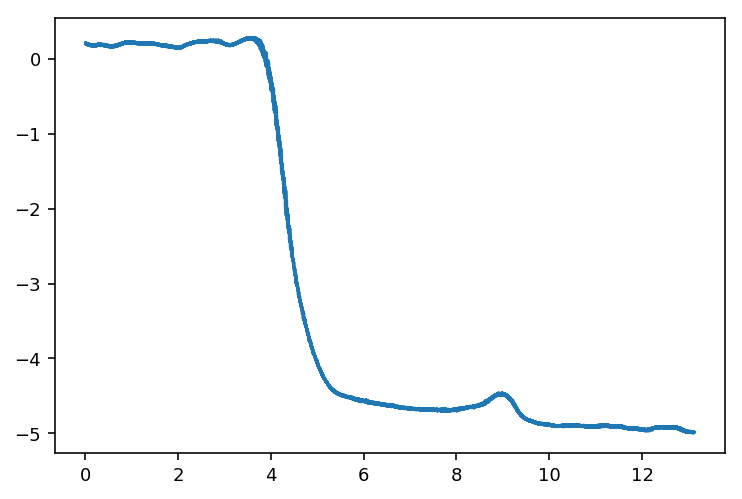

In [9]:
N = fh4['CPD'][:].size
CPD = fh4['CPD'][:]
X = (105*0.125*2)
nu_s = N/X
dx = X/N
x = np.arange(fh4['CPD'][:].size) * dx
Ndec = int(nu_s / 48)
plt.plot(x[:N//2], CPD[:N//2])

Response:
f   mag       dB
  0.000 1.000   -0.000
  1.500 0.983   -0.151
  3.000 0.927   -0.656
 12.000 0.095  -20.488
 24.000 0.000 -101.830
 50.000 0.000 -141.746
100.000 0.000 -159.241
9986.438 0.000 -337.057


(<matplotlib.figure.Figure at 0x116615590>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1165fae50>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1166eef90>))

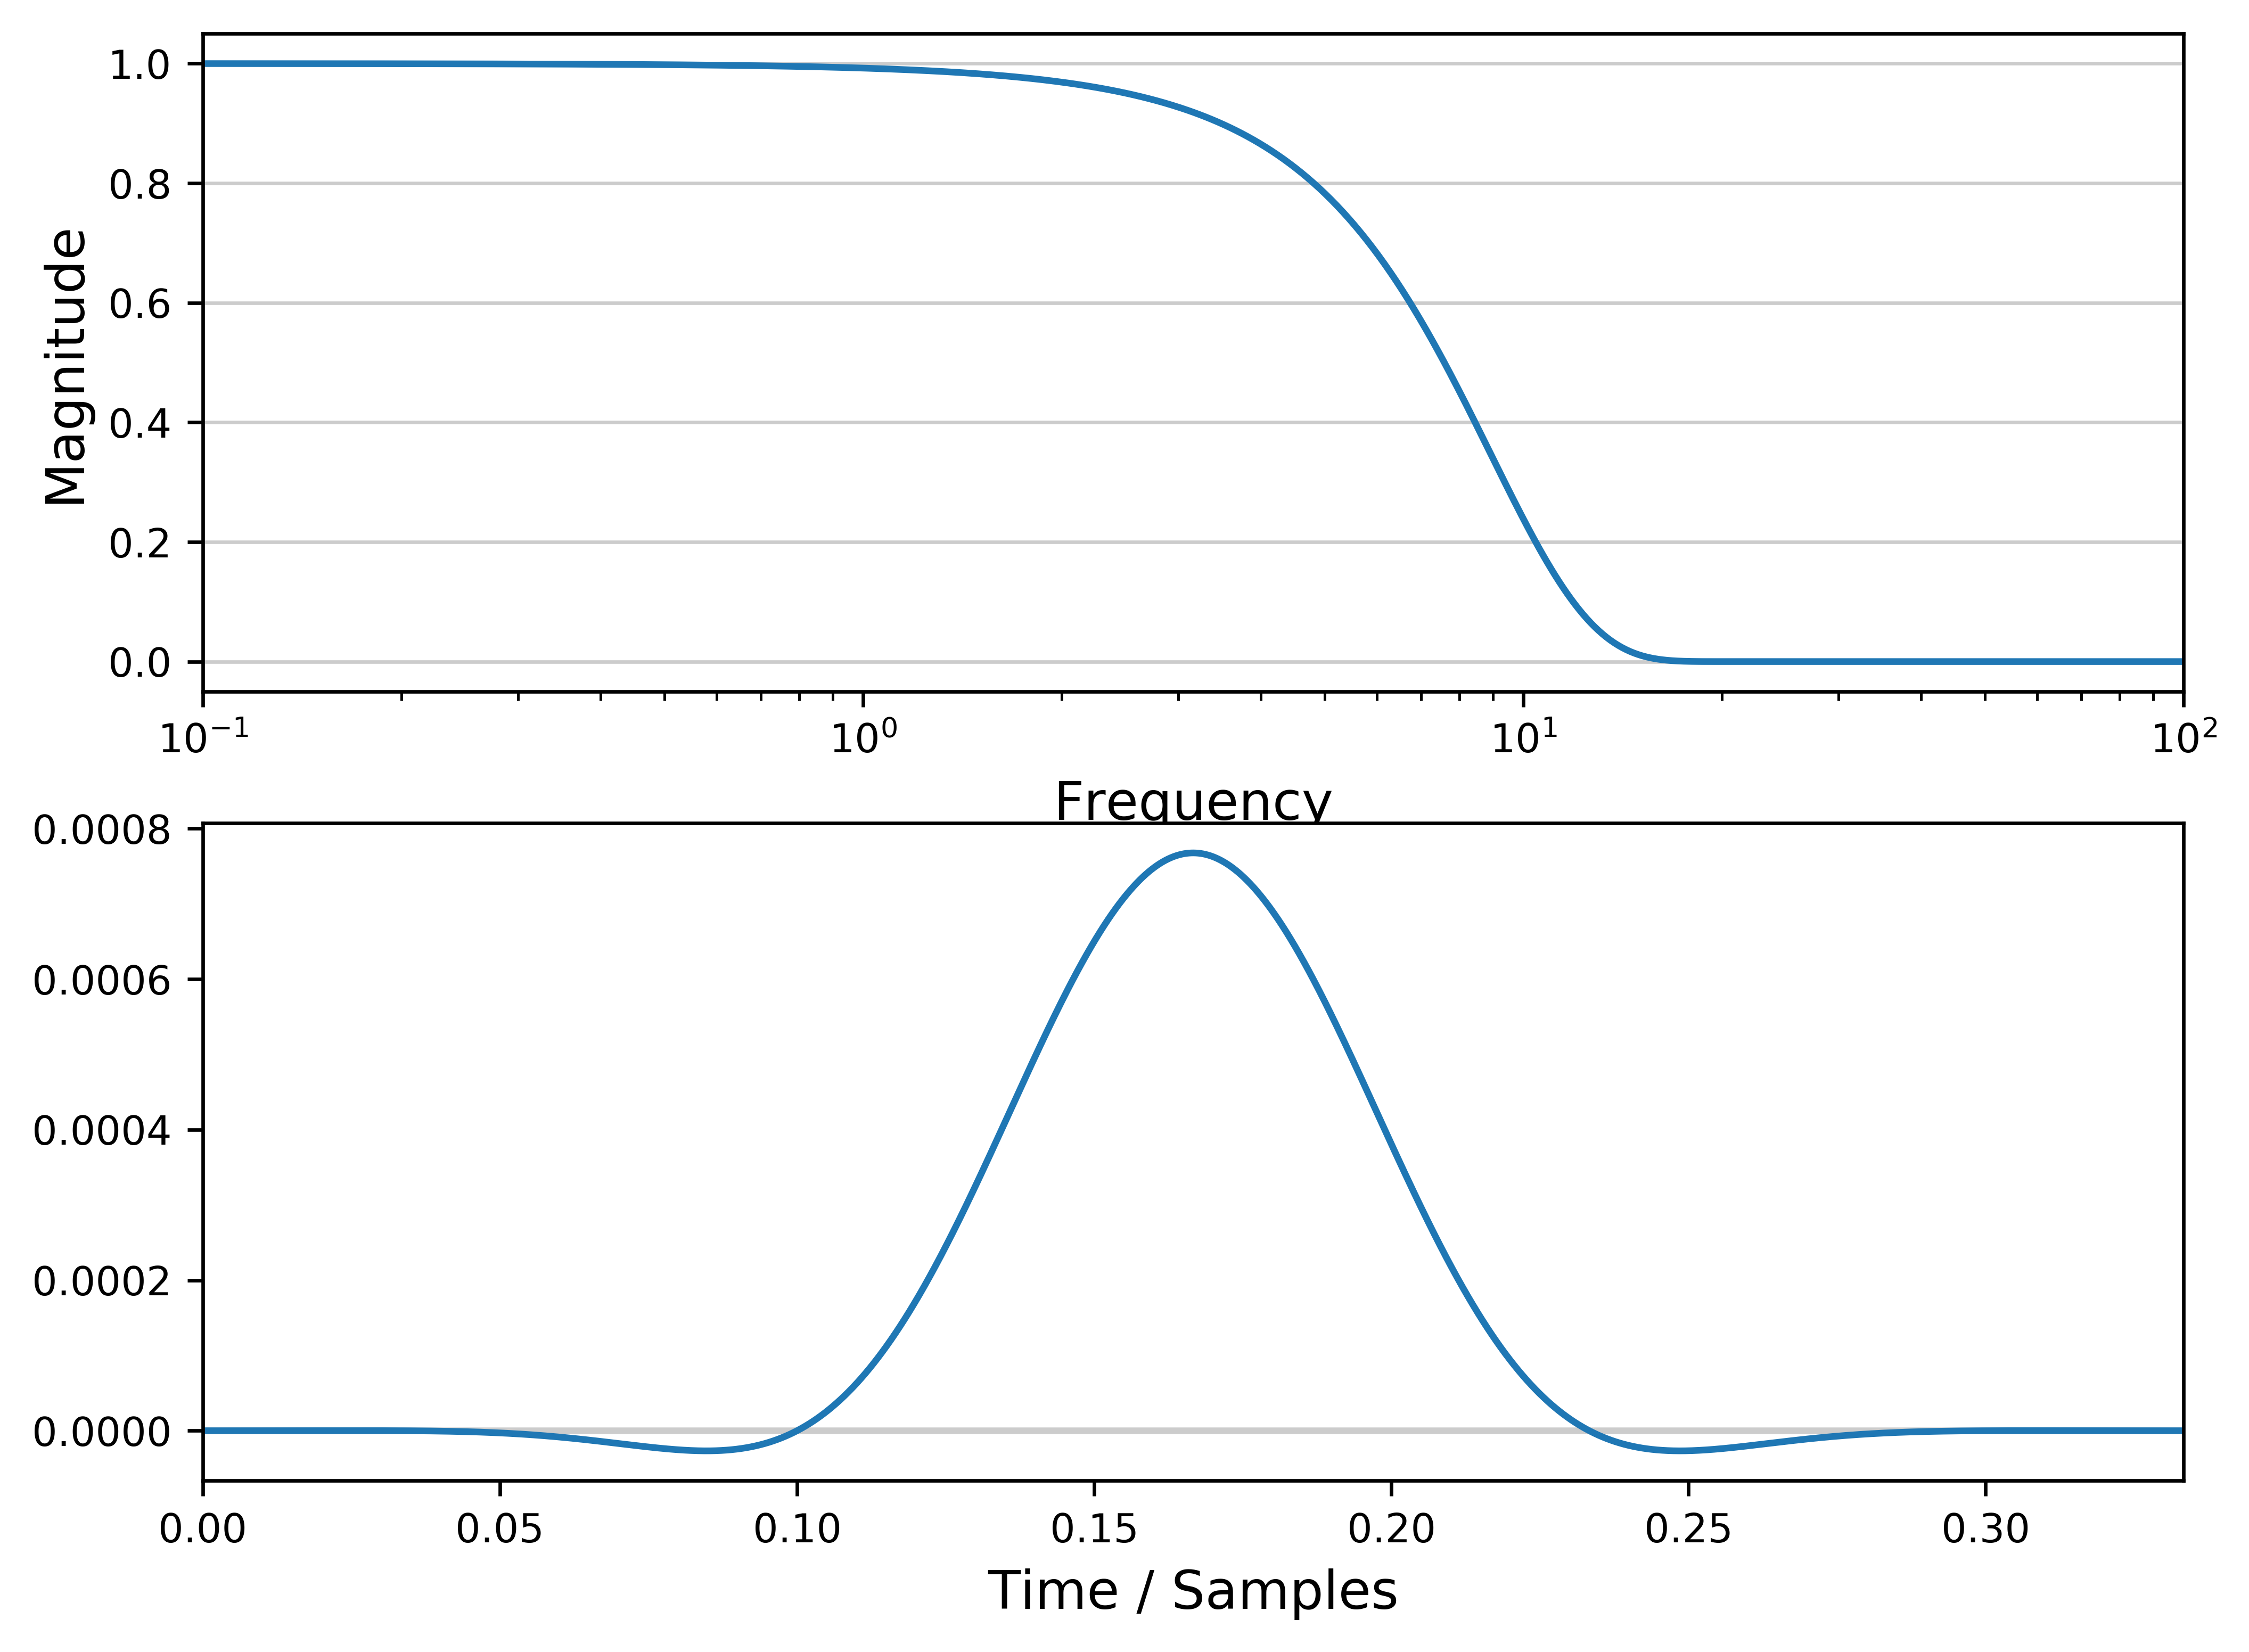

In [10]:
from sigutils import magtime_z
fir = lockin.lock2(100, 3,  12, fs=nu_s)

magtime_z(fir, fs=nu_s, dB=False, freq_log=True, freq_lim=(0.1, 100))

In [11]:
x_filt = signal.fftconvolve(x,fir, mode='same')
cpd_filt = signal.fftconvolve(CPD, fir, mode='same')
m = slice(0, x_filt.size//2, Ndec)

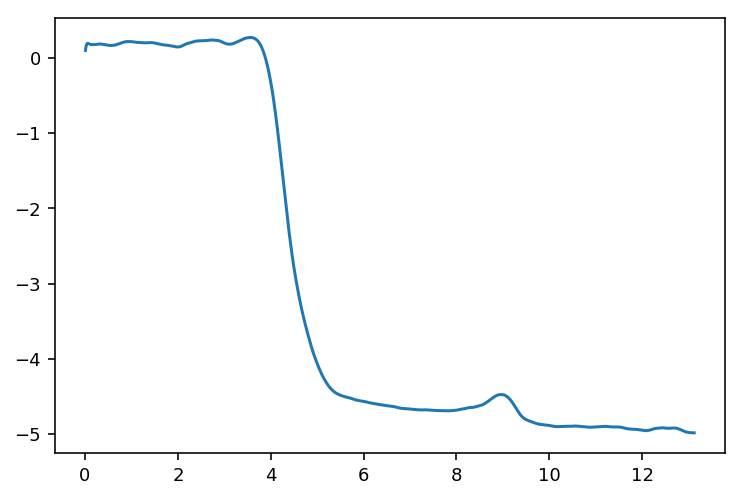

In [12]:
plt.plot(x_filt[m], cpd_filt[m])

In [13]:
import ipywidgets

In [14]:
from scipy.interpolate import interp1d

In [15]:
def ck(f, x0, A, k):
    out = integrate.quad(lambda theta: f(x0 + A * np.cos(theta)) * np.cos(theta*k), -np.pi, np.pi)
    if k == 0:
        return out[0]/(2*np.pi)
    else:
        return out[0]/np.pi

In [16]:
from scipy import interpolate
from scipy import integrate
from scipy.special import chebyt

In [17]:
    x0= 3.58
    A = 0.1
    zoom = (x_filt[m] > (x0 - A*1.1)) & (x_filt[m] < (x0 + A*1.1))
    zoom_interp = (x_filt[m] > (x0 - 2*A)) & (x_filt[m] < (x0 + 2*A))
    x = np.linspace(x0-A, x0+A)
    f = interpolate.UnivariateSpline(x_filt[m][zoom_interp], cpd_filt[m][zoom_interp], k=2, s=0)
    ks = np.arange(5)
    cs = [ck(f, x0, A, k) for k in ks]
    cts = np.array([c*chebyt(k)((x-x0)/A) for k, c in enumerate(cs)])

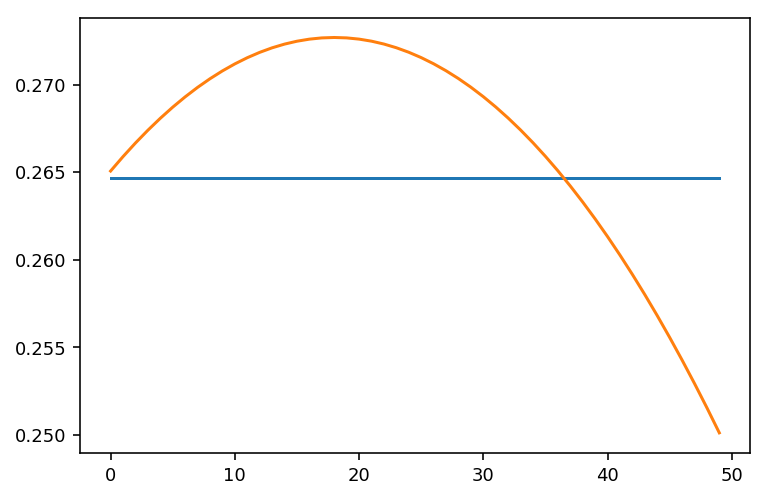

In [18]:
plt.plot(np.cumsum(cts, axis=0)[0])
plt.plot(np.cumsum(cts, axis=0)[2])

In [19]:
def zoomed(x0, A):
    zoom = (x_filt[m] > (x0 - A*1.1)) & (x_filt[m] < (x0 + A*1.1))
    zoom_interp = (x_filt[m] > (x0 - 2*A)) & (x_filt[m] < (x0 + 2*A))
    x = np.linspace(x0-A, x0+A)
    f = interpolate.UnivariateSpline(x_filt[m][zoom_interp], cpd_filt[m][zoom_interp], k=2, s=0)
    ks = np.arange(3)
    cs = [ck(f, x0, A, k) for k in ks]
    
    cts = np.array([c*chebyt(k)((x-x0)/A) for k, c in enumerate(cs)])
    
    plt.axvline(x0, color='0.7', linestyle=":", zorder=0)
    plt.axhline(f(x0), color='0.7', linestyle=":", zorder=0)
    plt.plot(x, f(x))
    plt.plot(x[20:30], f.derivative()(x0)*(x[20:30]-x0) + f(x0),
            zorder=10)
    plt.plot(x[20:30], 0.5*f.derivative(2)(x0)*(x[20:30]-x0)**2+f.derivative()(x0)*(x[20:30]-x0) + f(x0),
            zorder=9)
    plt.plot(x_filt[m][zoom], cpd_filt[m][zoom], 'o', mew=0)
    cts_polys = np.cumsum(cts, axis=0)
    for row in cts_polys[1:]:
        plt.plot(x, row)
    
    print(f.derivative()(x0))
    print(cs[1]/A)
    plt.show()

# Assume a linear approximation between data points

In [ ]:
ipywidgets.interact(zoomed, x0=(0, 10, 0.01), A=(0.015, 0.2, 0.015))

In [48]:
CPDfreq, CPD = signal.periodogram(fh4['CPD'][:]*1e3, fh4['CPD'][:].size/(105*0.125*2))

In [49]:
nus = (105*0.125*2)*fh4.attrs['Inputs.Scan rate [Hz]']
print(nus)

53760.0


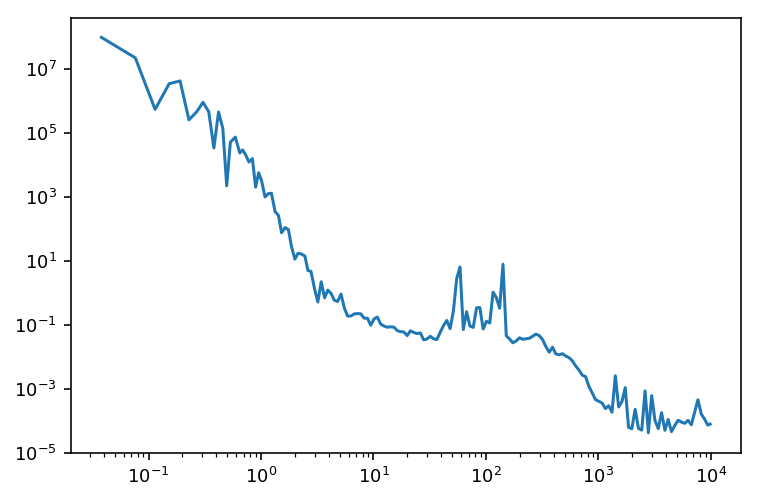

In [50]:
CPDfreqa, CPDa = log_bins(CPDfreq, abs(CPD), r=1.07)
plt.loglog(CPDfreqa, CPDa)


In [51]:
# fh = h5py.File('../data/KPFM-linescans/170217-', 'r')

In [52]:
ymod = OrderedDict([
    (0, ('../data/KPFM-linescans/170222-1512DPh-BTBT-20V-scan-y-no-mod.h5', False)),
    (15, ('../data/KPFM-linescans/170222-1507DPh-BTBT-20V-scan-y-15-nm-y-mod.h5', True)),
    (30, ('../data/KPFM-linescans/170222-1508DPh-BTBT-20V-scan-y-30-nm-y-mod.h5', False)),
    (45, ('../data/KPFM-linescans/170222-1511DPh-BTBT-20V-scan-y-45-nm-y-mod.h5', False))
])

In [53]:
py = workup_dict(ymod, Mod.y, fir, plot_phase=False)

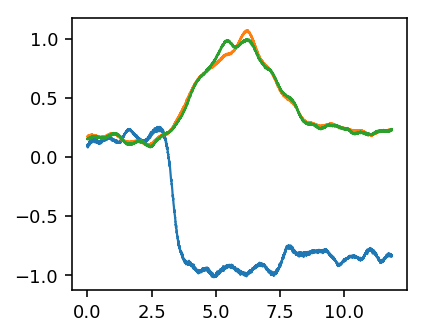

In [54]:
plt.rc('font', size=9)
plt.rc('text', usetex=False)
# plt.rcParams.update({'mathtext.fontset':'cm'})

fig, ax = plt.subplots(figsize=(3, 2.5))
ax.grid(which='both', color='1', linestyle='-', linewidth=0.75)
efm = py[0]
dec = 40
dec_pts = 160
i = dec_pts*dec//3 * 2
scale = 3.5
ax.plot(efm.x_dc[::dec], efm.phi[::dec], linewidth=1.1)
ax.plot(efm.x_dc[::dec], fh2['CPD'][:][::dec], linewidth=1.1)
ax.plot(efm.x_dc[::dec], fh3['CPD'][:][::dec], linewidth=1.1)

In [55]:
dx = np.mean(np.gradient(efm('x_dc')))
# dt = np.mean(np.gradient(efm('t')))
freq, PHI = signal.periodogram(efm.phi*1e3, fs=efm.phi.size/efm.x_dc[-1], window='blackman')

In [56]:
efm.x_dc[-1]/efm.dt

97279.62890625

In [57]:
efm.phi.size

262144

In [58]:
fh4['CPD']

<HDF5 dataset "CPD": shape (524288,), type "<f8">

In [59]:
dx = np.mean(np.gradient(efm('x_dc')))
# dt = np.mean(np.gradient(efm('t')))

freq2, PHI2 = signal.periodogram(fh2['CPD'][:]*1e3, fs=fh2['CPD'][:].size / efm.x_dc[-1], window='blackman')

In [60]:
fh2['CPD'][:].size / efm.x_dc[-1]

22075.368421373871

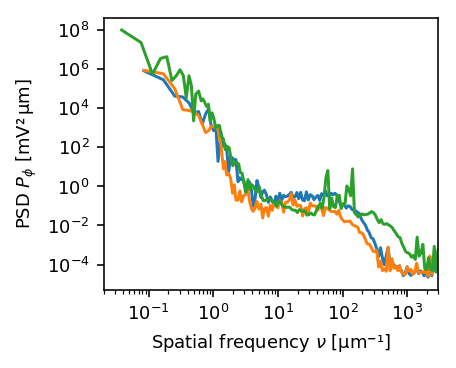

In [64]:
# Add upper y-axis
plt.rc('font', size=9)
plt.rc('text', usetex=False)
# plt.rcParams.update({'mathtext.fontset':'cm'})

fig, ax = plt.subplots(figsize=(3, 2.5))
ax.grid(which='both', color='1', linestyle='-', linewidth=0.75)
efm = py[0]
dec = 40
dec_pts = 160
i = dec_pts*dec//3 * 2
scale = 3.5
f, phi = log_bins(freq[1:], abs(PHI)[1:], 1.07)
f2, phi2 = log_bins(freq2[1:], abs(PHI2)[1:], 1.07)
# ax.loglog(freq, abs(PHI))
ax.loglog(f,phi)
ax.loglog(f2,phi2)
ax.loglog(CPDfreqa, CPDa)
ax.set_xlabel(u'Spatial frequency $\\nu$ [µm⁻¹]')
ax.set_ylabel(u'PSD $P_{\phi}$ [mV²$\\,$µm]')
ax.set_xlim(0.02, 3e3)
fig.savefig('../figs/83-psd.pdf', bbox_inches='tight')

In [ ]:
plt.rc('font', size=9)
plt.rc('text', usetex=False)
# plt.rcParams.update({'mathtext.fontset':'cm'})

fig, ax = plt.subplots(figsize=(3, 2.5))
ax.grid(which='both', color='1', linestyle='-', linewidth=0.75)
efm = py[0]
dec = 40
dec_pts = 160
i = dec_pts*dec//3 * 2
scale = 3.5
# f, phi = log_bins(freq[1:], abs(PHI)[1:], 1)
# f2, phi2 = log_bins(freq2[1:], abs(PHI2)[1:], 1.07)
# ax.loglog(freq, abs(PHI))
ax.loglog(freq,1.0 - np.cumsum(PHI)/np.sum(PHI))
ax.loglog(freq2,1.0-np.cumsum(PHI2)/np.sum(PHI2))
ax.plot(CPDfreq, 2.0 - np.cumsum(CPD)/(np.sum(CPD)/2))
ax.set_xlabel(u'Spatial frequency $\\nu$ [µm⁻¹]')
ax.set_ylabel(u'PSD $P_{\phi}$ [mV²$\\,$µm]')
ax.set_ylim(1e-5, 1)
# ax.set_xlim(0, 5)
# ax.set_ylim(0, 0.35e8)
# fig.savefig('../figs/83-psd.pdf', bbox_inches='tight')

In [65]:
!cp ../figs/83-psd.pdf /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201705__PMKPFM__figs/

In [ ]:
# dt = np.mean(np.gradient(efm('t')))
PHI3 = np.fft.rfft(py[45].phi*signal.windows.blackman(py[45].phi.size))
freq3 = np.fft.rfftfreq(py[45].phi.size, py[45].dt)

In [ ]:
plt.rc('font', size=9)
plt.rc('text', usetex=False)
# plt.rcParams.update({'mathtext.fontset':'cm'})

fig, ax = plt.subplots(figsize=(3, 2.5))
ax.grid(which='both', color='1', linestyle='-', linewidth=0.75)
efm = py[0]
dec = 40
dec_pts = 160
i = dec_pts*dec//3 * 2
scale = 3.5
f, phi = log_bins(freq[1:], abs(PHI)[1:], 1.07)
f2, phi2 = log_bins(freq2[1:], abs(PHI2)[1:], 1.07)
f3, phi3 = log_bins(freq2[1:], abs(PHI3)[1:], 1.07)
# ax.loglog(freq, abs(PHI))
ax.loglog(f,phi)
ax.loglog(f2,phi2)
# ax.loglog(f3, phi3, zorder=3)

In [ ]:
efm.phi

In [ ]:
dx = np.mean(np.gradient(efm.x_dc))
# dt = np.mean(np.gradient(efm('t')))
freq, PHI = signal.periodogram(efm.phi, 1/efm.dt, window='blackman')

In [ ]:
plt.rc('font', size=9)
plt.rc('text', usetex=False)
# plt.rcParams.update({'mathtext.fontset':'cm'})

fig, ax = plt.subplots(figsize=(3, 2.5))
ax.grid(which='both', color='1', linestyle='-', linewidth=0.75)
efm = py[0]
dec = 40
dec_pts = 160
i = dec_pts*dec//3 * 2
scale = 3.5
f, phi = log_bins(freq[1:], abs(PHI)[1:], 1.07)
# ax.loglog(freq, abs(PHI))
ax.loglog(f,phi)